<a href="https://colab.research.google.com/github/suresh-venkate/Code_Repositories/blob/main/Deep_Learning/Computer_Vision/Object_Detection/TF_Object_Detection_API/End_to_End_Training/TF_ObjDet_E2E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Object Detection API - End to End

# Complete all installations


In [1]:
%%capture

# Clone TF models repository from GitHUb
!git clone https://github.com/tensorflow/models

In [2]:
%%bash
cd models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf2/setup.py .
python -m pip install --quiet .

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.28.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


# Import required libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn import preprocessing

# Download Pascal VOC dataset

In [4]:
%%capture
%cd /content/ 
!mkdir Dataset 
%cd Dataset 

# Download xml_to_csv.py and generate-tfrecord.py
!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Computer_Vision/Object_Detection/TF_Object_Detection_API/End_to_End_Training/xml_to_csv.py
!wget https://raw.githubusercontent.com/suresh-venkate/Code_Repositories/main/Deep_Learning/Computer_Vision/Object_Detection/TF_Object_Detection_API/End_to_End_Training/generate_tfrecord.py

#Get PASCAL VOC dataset
!wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar --quiet
# Unzip tar file
!tar -xf VOCtrainval_06-Nov-2007.tar

# Define images folder and XMLs folder

In [5]:
img_path = '/content/Dataset/VOCdevkit/VOC2007/JPEGImages/'
xml_path = '/content/Dataset/VOCdevkit/VOC2007/Annotations/'

# Data Pre-processing : Convert XML to CSV

In [6]:
# Convert XML to CSV using script
!python xml_to_csv.py -i {xml_path} -o annot_data.csv
print()

# Load CSV file as dataframe
annot_df = pd.read_csv('annot_data.csv')
display(annot_df.head(5))
print()

# Print number of images with annotations
print("Total number of images is %d" %(annot_df.shape[0]))
# Print number of unique classes in dataset
print("Number of unique classes is %d" %(len(annot_df['class'].unique())))

Successfully converted xml to csv.



,filename,width,height,class,xmin,ymin,xmax,ymax
0,008568.jpg,500,375,boat,228,89,500,284
1,008568.jpg,500,375,boat,17,121,296,283
2,004439.jpg,500,334,car,326,250,438,307
3,004439.jpg,500,334,car,197,256,301,298
4,004439.jpg,500,334,car,131,258,179,285



Total number of images is 15607
Number of unique classes is 20


# Label encode classes

In [7]:
# Label Encode class and add a 'label' column to the dataframe
le = preprocessing.LabelEncoder()
annot_df['label'] = le.fit_transform(annot_df['class'])
# Object detection API expects index to start from 1 (and not 0)
annot_df['label'] = annot_df['label'] + 1

# Print list of unique classes and unique class labels
display(annot_df['class'].unique())
print()
display(annot_df['label'].unique())

array(['boat', 'car', 'bus', 'person', 'chair', 'tvmonitor', 'dog',
       'motorbike', 'pottedplant', 'horse', 'sofa', 'sheep', 'bird',
       'aeroplane', 'cow', 'diningtable', 'bottle', 'bicycle', 'train',
       'cat'], dtype=object)

array([ 4,  7,  6, 15,  9, 20, 12, 14, 16, 13, 18, 17,  3,  1, 10, 11,  5,
        2, 19,  8])

In [8]:
# Create a dictionary mapping from Label to Class. 
label_class_dict = dict(zip(annot_df['label'], annot_df['class']))
print(label_class_dict)

{4: 'boat', 7: 'car', 6: 'bus', 15: 'person', 9: 'chair', 20: 'tvmonitor', 12: 'dog', 14: 'motorbike', 16: 'pottedplant', 13: 'horse', 18: 'sofa', 17: 'sheep', 3: 'bird', 1: 'aeroplane', 10: 'cow', 11: 'diningtable', 5: 'bottle', 2: 'bicycle', 19: 'train', 8: 'cat'}


# Split data between training and test

In [9]:
# Get information on all images
all_images = annot_df['filename'].unique()
# Create train / test split (80% of data for training)
np.random.seed(0)
mask = np.random.rand(all_images.shape[0]) < 0.8

train_images = all_images[mask]
test_images = all_images[~mask] 

print("Number of train_images is %d" %(len(train_images)))
print("Number of test_images is %d" %(len(test_images)))
print()

# Split dataframe between training and test
train_df = annot_df[annot_df['filename'].isin(train_images)]
test_df = annot_df[annot_df['filename'].isin(test_images)]

print("Size of train_df is %d" %train_df.shape[0])
print("Size of test_df is %d" %test_df.shape[0])

Number of train_images is 4000
Number of test_images is 996

Size of train_df is 12495
Size of test_df is 3112


# Visualizing some images with BBoxes

## Training set

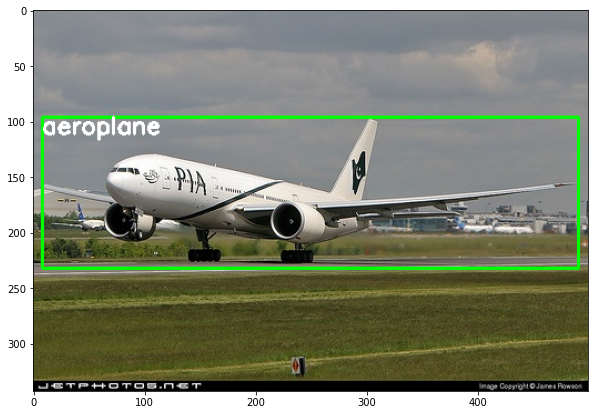

In [10]:
# Pickup a random image number
samp_ind = np.random.randint(0, train_df.shape[0], 1)[0]

# Read the image
img_file = train_df.iloc[samp_ind,0]
img = cv2.imread(img_path + '/' + img_file)

# Find all rows which have same file name
all_rows = train_df[train_df['filename'] == img_file].index.tolist()

# Draw BBoxes along with labels
for ind in all_rows:

    # Get bounding box co-ords
    xmin, ymin, xmax, ymax = train_df.loc[ind, ['xmin', 'ymin', 'xmax', 'ymax']]
    # Get Class of object
    obj_class = train_df.loc[ind, 'class']
    # Draw BBox
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    # Add text
    cv2.putText(img, obj_class, (xmin, ymin + 15), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw image using matplotlib
plt.figure(figsize = (10,7))
plt.imshow(img)
plt.show()

## Test Set

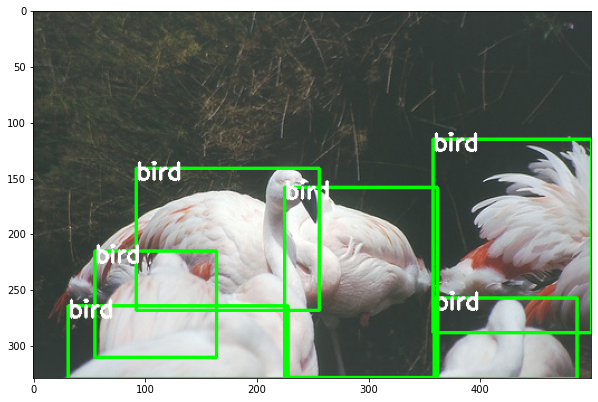

In [11]:
# Pickup a random image number
samp_ind = np.random.randint(0, test_df.shape[0], 1)[0]

# Read the image
img_file = test_df.iloc[samp_ind, 0]
img = cv2.imread(img_path + '/' + img_file)

# Find all rows which have same file name
all_rows = test_df[test_df['filename'] == img_file].index.tolist()

# Draw BBoxes along with labels
for ind in all_rows:

    # Get bounding box co-ords
    xmin, ymin, xmax, ymax = test_df.loc[ind, ['xmin', 'ymin', 'xmax', 'ymax']]
    # Get Class of object
    obj_class = test_df.loc[ind, 'class']
    # Draw BBox
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    # Add text
    cv2.putText(img, obj_class, (xmin, ymin + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

# Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Draw image using matplotlib
plt.figure(figsize = (10,7))
plt.imshow(img)
plt.show()

# Save training and test data as csv

In [12]:
train_df.to_csv('train.csv', index = False)
test_df.to_csv('test.csv', index = False)

# Generate tfrecord from CSV


In [13]:
%%capture

#Generate tfrecord for training data
!python generate_tfrecord.py --csv_input=train.csv --img_path={img_path} --output_path=train.tfrecord
#Generate tfrecord for test data
!python generate_tfrecord.py --csv_input=test.csv --img_path={img_path} --output_path=test.tfrecord

# Create Label Mapping File

In [ ]:
#Dict which was created earlier will be used for building Label Mapping file
label_class_dict

In [ ]:
#Build a pbtxt label file using label and class name
#This is required by Object detection API
#You can prepare it manually as well.

pbtxt_file_txt = ''
for label in sorted(label_class_dict.keys()):
    
    pbtxt_file_txt += "item {\n  id: " + str(label) + "\n  name: '" +  label_class_dict[label] + "'\n}\n\n"

with open('label_map.txt','w') as pbfile:
    pbfile.write(pbtxt_file_txt)

In [ ]:
!ls -l

In [ ]:
#Review the file content
!cat label_map.txt

#### 6. Download a pre-trained model

A list of pre-trained models is available at [TensorFlow model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf1_detection_zoo.md). We will use 'ssd_mobilenet_v1_coco' model for transfer learning.

In [ ]:
#Download the model from zoo
!wget -q http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz

In [ ]:
!ls -l

In [ ]:
#Extract tar file content
!tar -xf ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz

In [ ]:
!ls -l

In [ ]:
#Check the extracted folder
!ls -l ssd_mobilenet_v2_320x320_coco17_tpu-8

In [ ]:
#Check the extracted folder
!ls -l ssd_mobilenet_v2_320x320_coco17_tpu-8/checkpoint

#### 7. Prepare Training configuration file

1. Change num_classes parameter to 20 (as we have 20 categories in pascal voc dataset)
2. For 'train_input_reader' change 'input_path' to filepath of train.record file.
3. For 'train_input_reader' change 'label_map_path' to filepath of pascal_voc.pbtxt file.
4. Repeat above two steps for 'eval_input_reader'.
5. Change fine_tune_checkpoint to filepath where pre-trained model.ckpt file is available e.g ssd_mobilenet_v1_coco_2018_01_28/model.ckpt
6. Change 'batch_size' accordingly to available memory.
7. Change 'num_steps' to indicate how long the training will done e.g. 200000. For demo purpose, we are keeping it to 20 so that we can finish training quickly.


You can copy a sample configuration for the chosen pre-trained model (SSD MobileNet v2 320x320) in this case from [Configs](https://github.com/tensorflow/models/tree/master/research/object_detection/configs/tf2) folder. Here are things which need to be changed at a minimum.

In [ ]:
#Copy ssd_mobilenet_v2_modified.config from drive to current directory. 
#Change gdrive folder if you have saved script in some other folder
!cp '/gdrive/MyDrive/AI_ML_Folder/Colab_Directory/TF_ObjDet/ssd_mobilenet_v2_modified.config' . 

In [ ]:
!cat  ssd_mobilenet_v2_modified.config

Set Config file name

In [ ]:
config_file = 'ssd_mobilenet_v2_modified.config'

#### 8. Training the model

In [ ]:
#Copy training file from 'models/research/object_detection' folder to current folder
!cp /content/models/research/object_detection/model_main_tf2.py .

In [ ]:
!ls -l

Start training 

- Please note that Object detection take long time to train. The training may take few days if run on single GPU machine (depending on num of steps indicated). Try to keep training the model till loss comes close to 1 (or goes below 1). The script takes 3 inputs

1. --train_dir=<folder_name> : where model will be saved periodically as training progresses
2. --pipeline_config_path=<config_file_path> :where is model training configuration file located.

In [ ]:
#Create a training folder to store model checkpoints/snapshots as training progresses
!mkdir training

In [ ]:
#Check training folder
!ls -l training

Start Tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir training

In [ ]:
#start training
!python model_main_tf2.py --model_dir=training/ --pipeline_config_path={config_file} --checkpoint_every_n=100 --alsologtostderr

Model Evaluation

In [ ]:
#start Evaluation - THIS WILL KEEP RUNNING.
!python model_main_tf2.py --model_dir=training/ --pipeline_config_path={config_file} --checkpoint_dir=training/ --alsologtostderr 

#### Training and Evaluation in Background

If we want to evaluate our model on training data regularly, we have to run both training and evaluation script in parallel. Model evaluation on test data gets done everytime model checkpoint is saved during training.

In [ ]:
#Start training
!nohup /usr/bin/python3 model_main_tf2.py --model_dir=training/ --pipeline_config_path={config_file} --checkpoint_every_n=500 --alsologtostderr --eval_training_data --sample_1_of_n_eval_on_train_examples=10  > train.txt 2>&1 &

In [ ]:
!nohup /usr/bin/python3 model_main_tf2.py --model_dir=training/ --pipeline_config_path={config_file} --checkpoint_dir=training/ --alsologtostderr > eval.txt 2>&1 &

In [ ]:
!cat train.txt

In [ ]:
!cat eval.txt

In [ ]:
#Check the training folder
!ls -l training

#### 9. Export trained model

From the saved model checkpoints, we will create a frozen trained model. Frozen here means to remove model nodes which are no longer needed in prediction. This reduces model size.

In [ ]:
#Copy export_inference_graph.py file from models/research/object_detection to current directory
!cp /content/models/research/object_detection/exporter_main_v2.py .

In [ ]:
!ls -l

The export_inference_graph.py script file requires the following input:

1. --input_type <input_node_name> : This will be used during prediction to set model input
2. --pipeline_config_path <model_training_config_file_path> : where is model training config file located.
3. --trained_checkpoint_prefix <file_path__model_checkpoint> : Which checkpoint should be used to create final model.
4. --output_directory <frozen_model_directory> : where should the frozen model created by script should be stored.

In [ ]:
#Provide input name, config file location, training folder
!python exporter_main_v2.py --input_type "image_tensor" --pipeline_config_path {config_file} --trained_checkpoint_dir training/ --output_directory detection_model

In [ ]:
#Check if model is saved in current directory
!ls -l detection_model

In [ ]:
#Check if model is saved in current directory
!ls -l detection_model/saved_model

In [ ]:
!ls -l detection_model/saved_model/variables/

In [ ]:
!ls -l detection_model/saved_model/assets

#### Move the trained model to Google Drive

In [ ]:
!cp -r detection_model '/gdrive/MyDrive/AI_ML_Folder/Colab_Directory/TF_ObjDet/pascal_voc_tf2/' 

Save label dictionary as well for model prediction

In [ ]:
print(label_class_dict)

In [ ]:
import pickle

label_file_path = '/gdrive/MyDrive/AI_ML_Folder/Colab_Directory/TF_ObjDet/pascal_voc_label.pkl'

with open(label_file_path,'wb') as file:
    pickle.dump(label_class_dict, file)

#### Model Prediction

In [ ]:
import tensorflow as tf

Load Saved model

In [ ]:
saved_model_path = 'detection_model/saved_model'
model = tf.saved_model.load(saved_model_path)

Function to get model prediction

In [ ]:
#Function to get predictions from a Detection model
def detector_prediction(image_file, confidence_threshold=0.5):

    """
    image_file: File path of the image for which prediction needs to be done
    confidence_threshold: Minimum confidence/probability for prediction to be considered
    """
    #Load image
    img = tf.keras.preprocessing.image.load_img(image_file)
    
    #Convert to numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')
    #Make it a batch of one example
    img_array = tf.expand_dims(img_array, axis=0)

    #Prediction
    output = model(img_array) #get list of tensors discussed above as output
    #print(output)
    detection_scores = output['detection_scores'].numpy()[0] #get detection scores
    detection_classes = output['detection_classes'].numpy()[0]
    detection_boxes = output['detection_boxes'].numpy()[0]

    #Select predictions for which probability is higher than confidence_threshold
    selected_predictions = detection_scores >= confidence_threshold

    selected_prediction_scores = detection_scores[selected_predictions]
    selected_prediction_classes = detection_classes[selected_predictions]
    selected_prediction_boxes = detection_boxes[selected_predictions]

    #De-normalize box co-ordinates (multiply x-coordinates by image width and y-coords by image height)
    img_w, img_h = img.size

    for i in range(selected_prediction_boxes.shape[0]):
        
        selected_prediction_boxes[i,0] *= img_h #ymin * img_w
        selected_prediction_boxes[i,1] *= img_w #xmin * img_h
        selected_prediction_boxes[i,2] *= img_h #ymax * img_w
        selected_prediction_boxes[i,3] *= img_w #xmax * img_h

    #Make all co-ordinates as integer
    selected_prediction_boxes= selected_prediction_boxes.astype(int)

    #Convert class indexes to actual class labels
    predicted_classes = []
    for i in range(selected_prediction_classes.shape[0]):
        predicted_classes.append(label_class_dict[int(selected_prediction_classes[i])])

    #Number of predictions
    selected_num_predictions = selected_prediction_boxes.shape[0]

    return {'Total Predictions': selected_num_predictions,
            'Scores': selected_prediction_scores, 
            'Classes': predicted_classes, 
            'Box coordinates': selected_prediction_boxes}

Copy an image to predict on

In [ ]:
!cp '/gdrive/MyDrive/AI_ML_Folder/Colab_Directory/TF_ObjDet/person_with_bike.jpg' .

In [ ]:
!ls -l

In [ ]:
#Model output
detector_prediction('person_with_bike.jpg', confidence_threshold=0.2)

Visualize model output

In [ ]:
import cv2
from matplotlib import pyplot as plt

In [ ]:
def visualize_output(image_file, confidence_threshold=0.5):

    #Call model prediction function above
    output = detector_prediction(image_file, confidence_threshold=confidence_threshold)

    #Read image
    img = cv2.imread(image_file)

    #Draw rectangle for predicted boxes, also add predicted classes
    for i in range(output['Box coordinates'].shape[0]):

        box = output['Box coordinates'][i]
        
        #Draw rectangle - (ymin, xmin, ymax, xmax)
        img = cv2.rectangle(img, (box[1], box[0]), (box[3], box[2]), (0,255,0), 2)
        
        #Add Label - Class name and confidence level
        label = output['Classes'][i] + ': ' + str(round(output['Scores'][i],2))
        img = cv2.putText(img, label, (box[1], box[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    #Conver BGR image to RGB to use with Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Display image
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.show()

In [ ]:
#Visualize on image
visualize_output('person_with_bike.jpg', confidence_threshold=0.7)